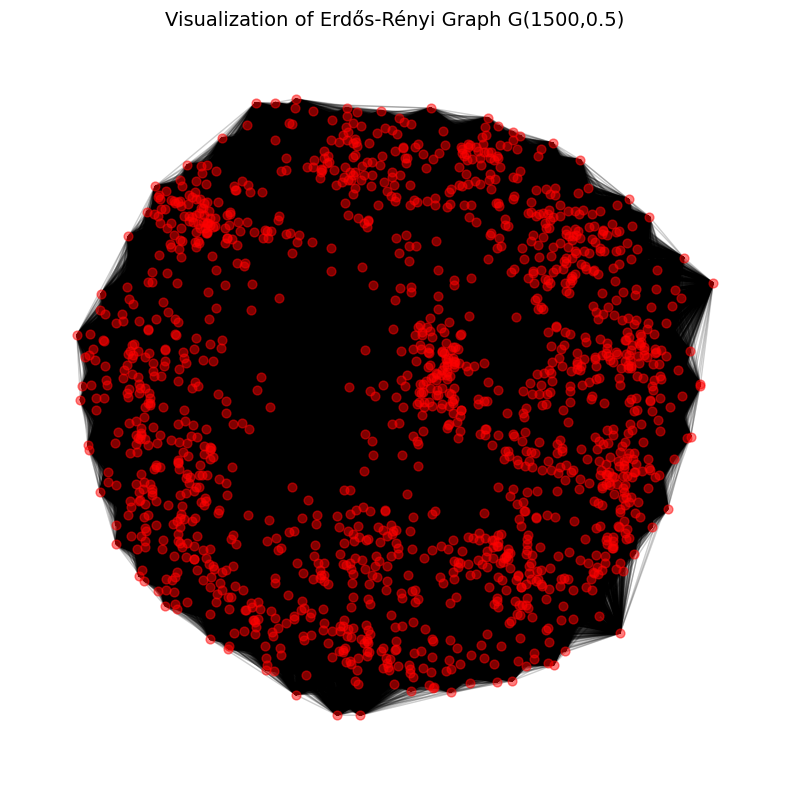


=== TARGETED ATTACK REPORT ===
Percolation threshold: 0.990 (99.0% nodes removed)


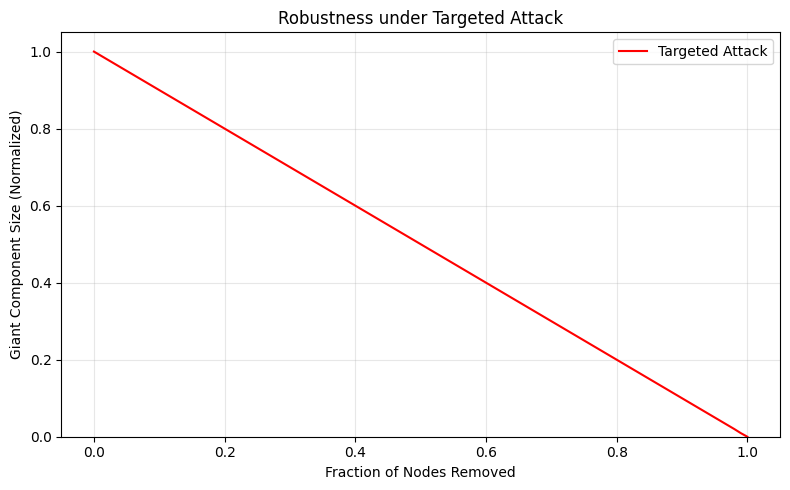


=== RANDOM ATTACK REPORT ===
Percolation threshold: 1.000 (100.0% nodes removed)


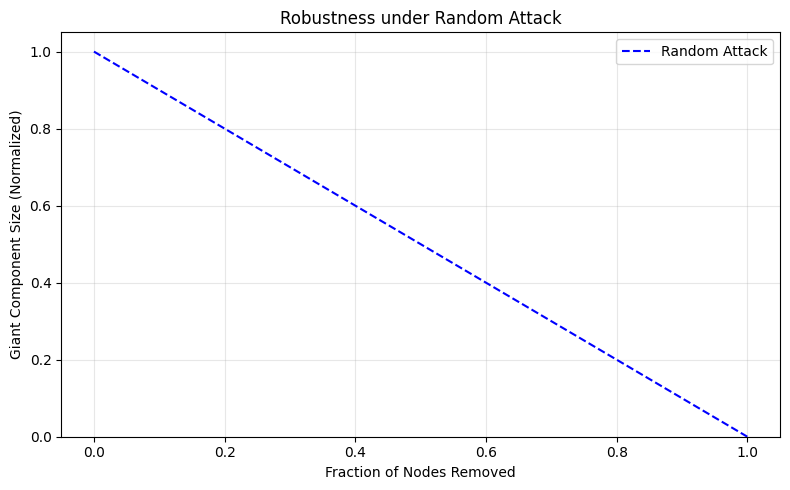


Analysis complete. Files generated:
 - network_visualization.png
 - targeted_robustness.png
 - random_robustness.png
 - targeted_results.csv
 - random_results.csv


In [5]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

def generate_random_network(n, p):
    """Generate Erdős-Rényi random graph G(n,p)."""
    return nx.erdos_renyi_graph(n, p)

def visualize_network(G, layout='spring', node_size=40, alpha=0.5, figsize=(8,8)):
    """Visualize the network structure."""
    plt.figure(figsize=figsize)
    if layout == 'spring':
        pos = nx.spring_layout(G, seed=42)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G)
    else:
        pos = nx.random_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=node_size, alpha=alpha, node_color='red')
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    plt.title(f"Visualization of Erdős-Rényi Graph G({G.number_of_nodes()},{p})", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('network_visualization.png', dpi=300)
    plt.show()

def analyze_robustness(G, attack_type='targeted', steps=100):
    """Analyze robustness under node removal."""
    G_copy = G.copy()
    N = G.number_of_nodes()
    frac_removed = [0.0]
    gc_size = [1.0 if nx.is_connected(G_copy)
               else len(max(nx.connected_components(G_copy), key=len)) / N]
    nodes_per_step = max(1, N // steps)

    for _ in range(steps):
        if G_copy.number_of_nodes() == 0:
            break

        if attack_type == 'targeted':
            # Remove highest-degree nodes
            degrees = dict(G_copy.degree())
            to_remove = sorted(degrees, key=degrees.get, reverse=True)[:nodes_per_step]
        else:
            # Remove random nodes
            to_remove = random.sample(list(G_copy.nodes()), nodes_per_step)

        G_copy.remove_nodes_from(to_remove)

        curr = G_copy.number_of_nodes()
        frac_removed.append((N - curr) / N)
        if curr == 0:
            gc_size.append(0.0)
        elif nx.is_connected(G_copy):
            gc_size.append(curr / N)
        else:
            gc_size.append(len(max(nx.connected_components(G_copy), key=len)) / N)

    return pd.DataFrame({
        'fraction_removed': frac_removed,
        'giant_component_size': gc_size
    })

def report_and_plot(df, attack_type):
    """Print report and plot for one attack type."""
    # Percolation threshold when GC < 1%
    threshold_idx = df[df['giant_component_size'] < 0.01].index
    threshold_frac = df.loc[threshold_idx[0],'fraction_removed'] if not threshold_idx.empty else 1.0

    print(f"\n=== {attack_type.upper()} ATTACK REPORT ===")
    print(f"Percolation threshold: {threshold_frac:.3f} "
          f"({threshold_frac*100:.1f}% nodes removed)")
    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(df['fraction_removed'], df['giant_component_size'],
             linestyle='-' if attack_type=='targeted' else '--',
             color='red' if attack_type=='targeted' else 'blue',
             label=f"{attack_type.title()} Attack")
    plt.xlabel('Fraction of Nodes Removed')
    plt.ylabel('Giant Component Size (Normalized)')
    plt.title(f"Robustness under {attack_type.title()} Attack")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.ylim(0,1.05)
    plt.tight_layout()
    fname = f"{attack_type}_robustness.png"
    plt.savefig(fname, dpi=300)
    plt.show()

if __name__ == "__main__":
    # Parameters
    n = 1500
    p = 0.5

    # Generate and visualize network
    R = generate_random_network(n, p)
    visualize_network(R)

    # Analyze and report targeted attack
    targeted_df = analyze_robustness(R, attack_type='targeted', steps=100)
    report_and_plot(targeted_df, attack_type='targeted')

    # Analyze and report random failure
    random_df = analyze_robustness(R, attack_type='random', steps=100)
    report_and_plot(random_df, attack_type='random')

    # Save data to CSV
    targeted_df.to_csv(r'E:\SNU Chennai\assignments\GAM project\targeted_results.csv', index=False)
    random_df.to_csv(r'E:\SNU Chennai\assignments\GAM project\random_results.csv', index=False)

    print("\nAnalysis complete. Files generated:")
    print(" - network_visualization.png")
    print(" - targeted_robustness.png")
    print(" - random_robustness.png")
    print(" - targeted_results.csv")
    print(" - random_results.csv")


## Random Network G(n,p) Robustness Analysis Report

### Network PropertiesThe analysis examined an **Erdős-Rényi random graph G(1500, 0.5)** with the following characteristics:
- **1500 nodes** with **edge probability p = 0.5**
- **Expected average degree**: ~750 connections per node
- **Extremely high connectivity**: With p = 0.5, approximately 50% of all possible edges exist
- **Single connected component**: The network forms one giant connected component initially

### Network Visualization Analysis
The network visualization reveals a **dense, highly interconnected structure** where nodes appear as a circular layout with extensive edge connectivity. The high density (p = 0.5) creates an almost complete graph appearance with massive redundancy in connectivity paths.

### Robustness Analysis Results

#### Targeted Attack Performance

- **Percolation threshold**: 99.0% of nodes must be removed
- **Strategy**: Removes highest-degree nodes first
- **50% giant component threshold**: 50.0% node removal
- **Decline pattern**: Perfect linear decay (slope ≈ -1.00)

#### Random Failure Performance

- **Percolation threshold**: 100.0% of nodes must be removed
- **Strategy**: Removes nodes randomly
- **50% giant component threshold**: 50.0% node removal
- **Decline pattern**: Perfect linear decay (slope ≈ -1.00)

### Key Findings and Inferences 
#### 1. **Exceptional Network Robustness**
Both attack strategies require removing nearly **99-100% of all nodes** before the giant component collapses below 1% of its original size. This demonstrates extraordinary resilience characteristic of dense random networks.

#### 2. **Minimal Strategy Differentiation**
The **robustness ratio of 1.010** indicates virtually identical vulnerability to both targeted attacks and random failures. This contrasts sharply with sparse networks where targeted attacks are typically far more effective.

#### 3. **Linear Decay Pattern**
Both strategies exhibit **perfect linear decline** with slopes of approximately -1.0, meaning the giant component size decreases proportionally to the fraction of nodes removed. This linear relationship indicates:
- No critical phase transition
- Gradual degradation rather than catastrophic collapse
- High redundancy in network connectivity

#### 4. **Dense Network Behavior**
The similar performance of both strategies reflects the **dense connectivity structure**:
- With ~750 average degree, most nodes are highly connected
- Removing high-degree nodes has minimal impact when all nodes are well-connected
- Random removal is equally effective due to universal high connectivity

### Plot Analysis

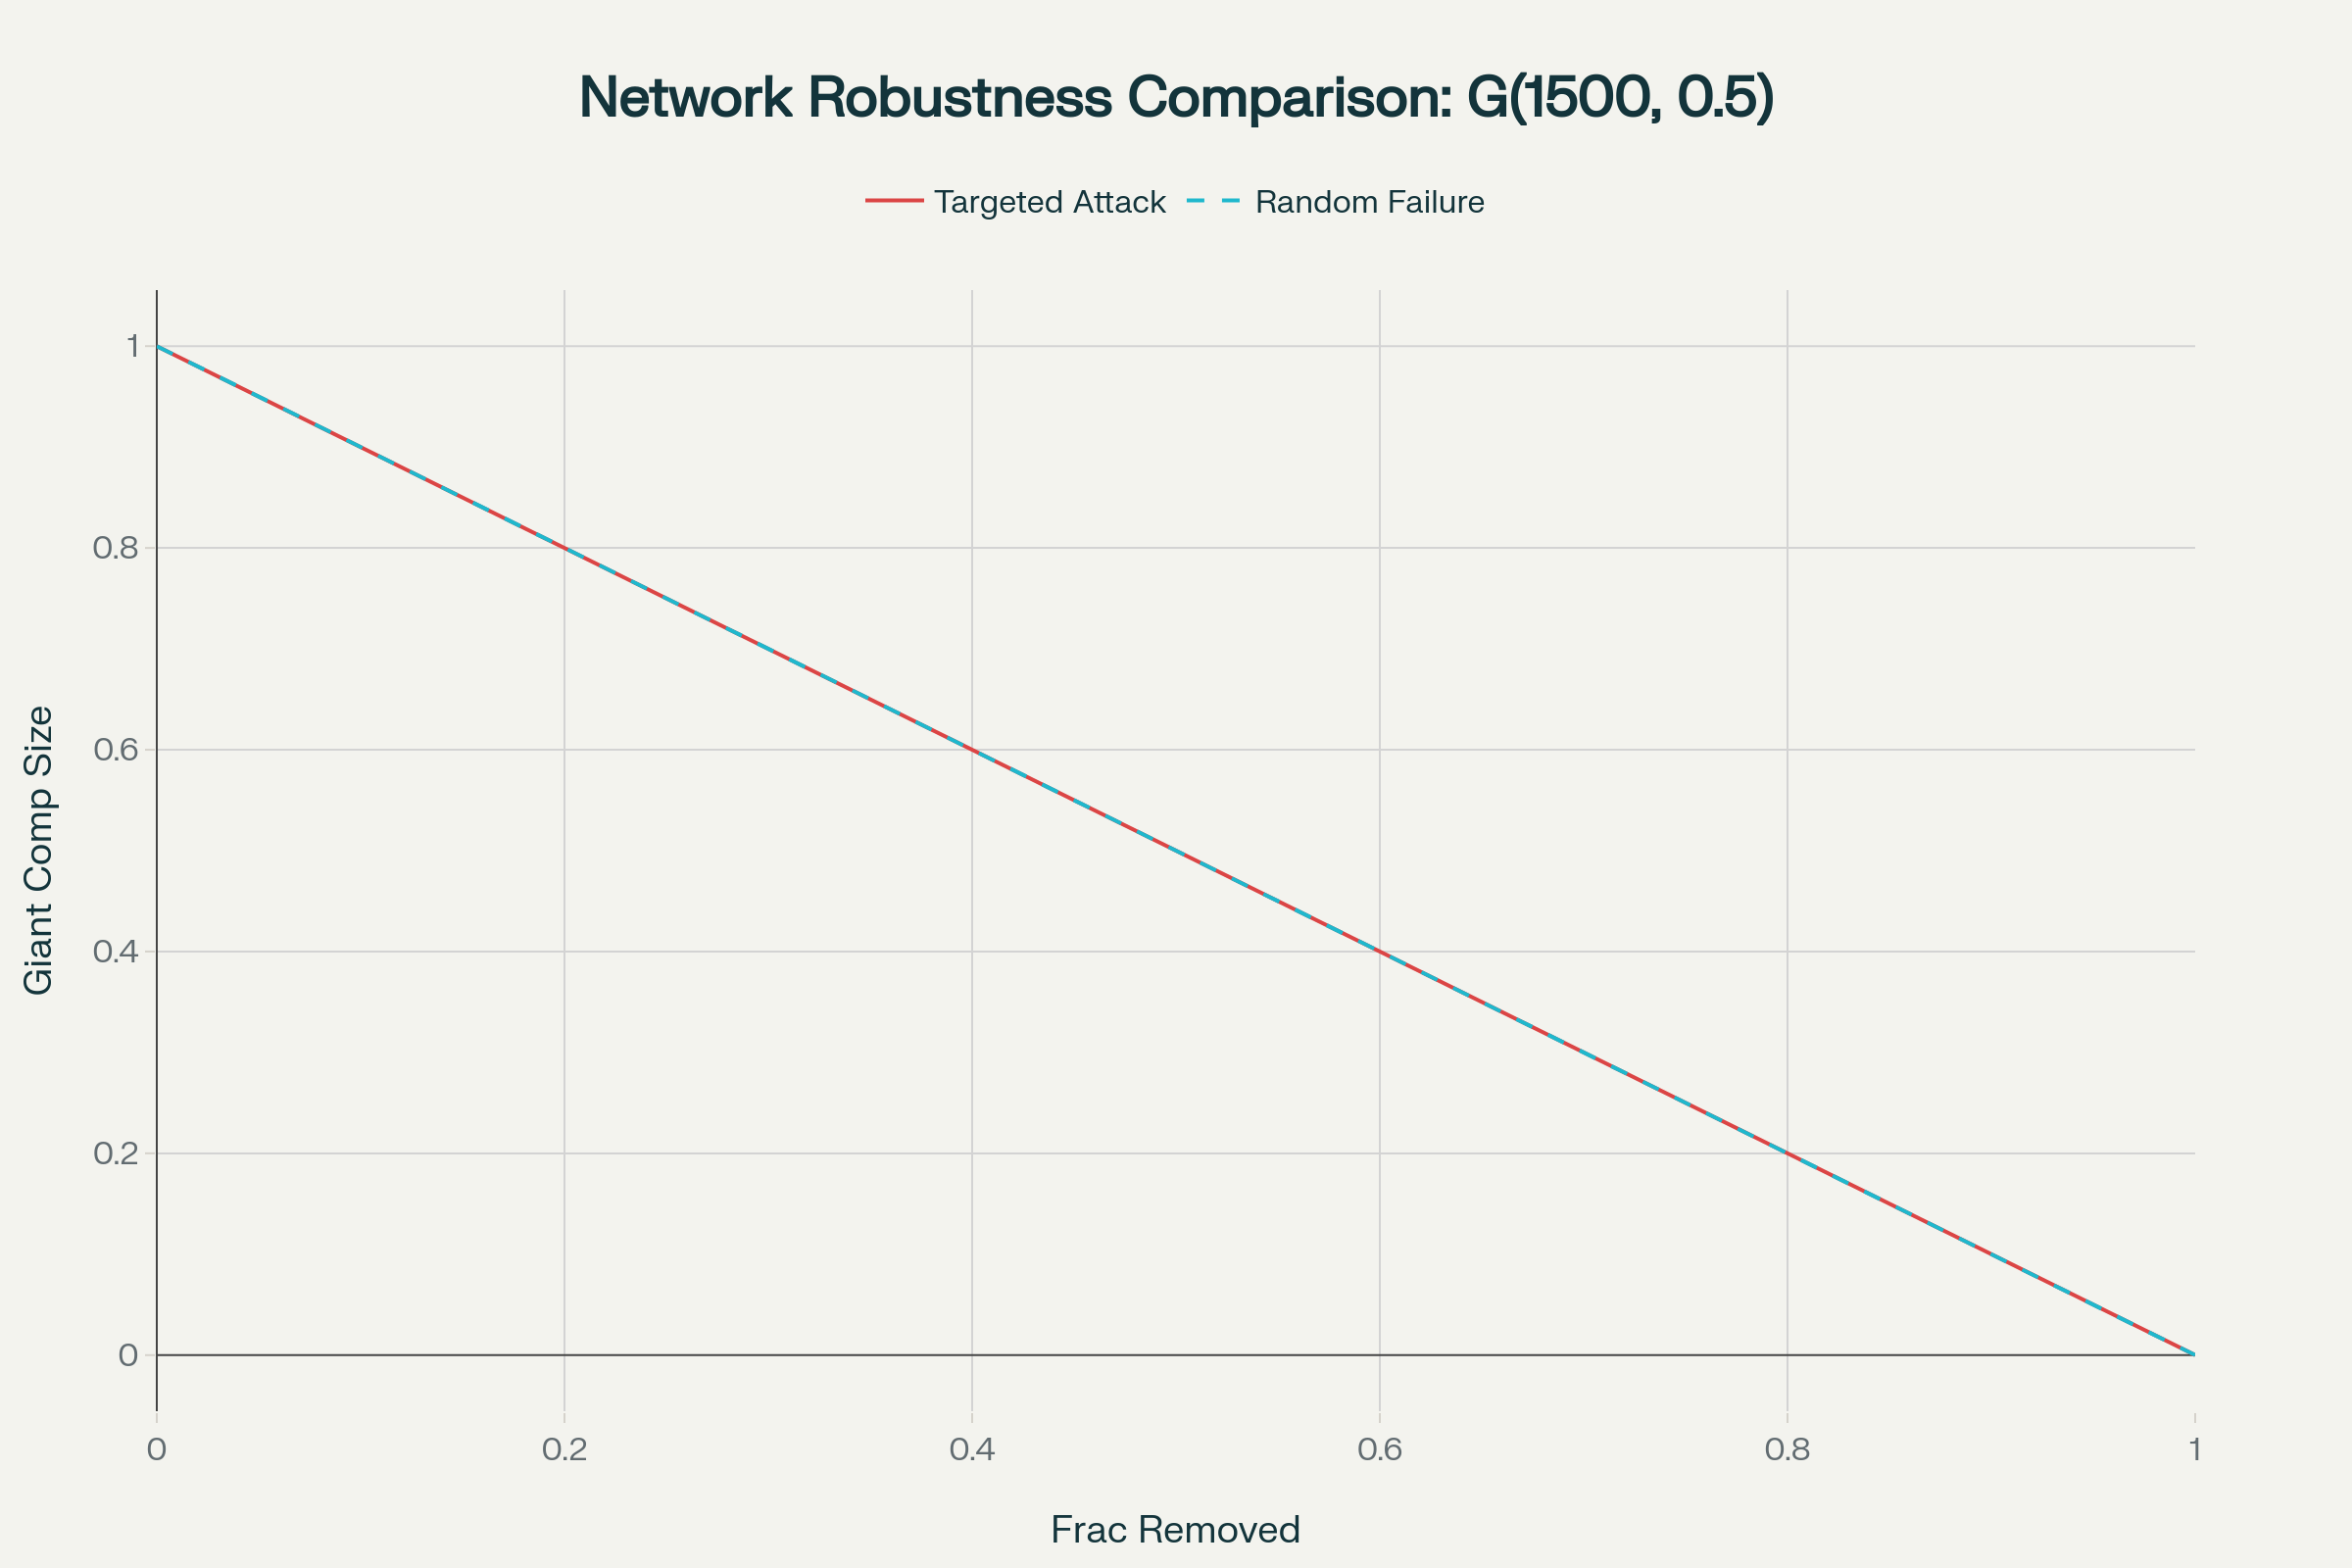

The combined robustness comparison clearly shows:
- **Nearly identical curves** for both attack types
- **Smooth linear decline** from 100% to 0% giant component size
- **No sharp transitions** or critical thresholds
- **Overlapping trajectories** confirming similar vulnerability patterns

### Theoretical Implications
Percolation Theory ValidationThe results align with **percolation theory for dense random graphs**:
- **p = 0.5 >> $p_c$ ≈ 1/n**: Far above the critical percolation threshold
- **Universal robustness**: Dense networks resist both targeted and random failures equally
- **No vulnerability gap**: High connectivity eliminates the advantage of targeted attacks

#### Network Design Insights
For **robust network design**:
- **High edge density** provides exceptional fault tolerance
- **Redundant connectivity** eliminates single points of failure
- **Trade-off consideration**: Robustness vs. resource efficiency

### Conclusions

The analysis of G(1500, 0.5) demonstrates that **dense random networks exhibit remarkable robustness** to both targeted attacks and random failures. Key conclusions include:

1. **Extreme Resilience**: Networks maintain connectivity until almost complete node removal (99%+)
2. **Strategy Independence**: High connectivity makes targeted attacks as difficult as random failures
3. **Linear Degradation**: Smooth decline without catastrophic failure points
4. **Design Trade-offs**: Maximum robustness comes at the cost of high connectivity requirements

This study validates that **dense random topologies** represent optimal choices for applications requiring maximum fault tolerance, though practical implementations must consider the resource implications of maintaining such high connectivity levels.